# This book generates an ARIMA model on daily corn, exactly as described in Wang paper

## Assumptions, where Wang paper lacks detail:
### - assumptions made regarding when train and valid used versus train alone
### - assumed once stationarity is achieved with one differencing, no other attempts to satisfy ARIMA assumptions are made
### - assume some sort of reference to ACF/PACF in limiting model order search
### - assume no attempt at incorporating a seasonal component
### - since it is not mentioned how AIC and BIC are combined, only AIC is used in model comparison, becuase all data used in order search here is same sample size

### CONTENTS
### 1 Installations and imports
### 2 Check stationarity assumption
### 3 Visualise ACF and PACF
### 4 Investigate model order
### 5 Generate validation set predictions

# 1 Installations and imports

In [1]:
# ARIMA installations

!pip install pmdarima
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 15.2 MB/s 
     |████████████████████████████████| 9.8 MB 57.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
# ARIMA imports

from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm #Auto arima
from statsmodels.tsa.stattools import acf #Metrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [2]:
#General imports

import numpy as np
import pandas as pd

import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.dates

from datetime import datetime

from google.colab import drive
import json

In [3]:
# Import daily data

data_url = 'https://raw.githubusercontent.com/ptraver/data/main/corn_daily_V2.csv'
corn_df = pd.read_csv(data_url, parse_dates=True, dayfirst=True, index_col='date')

# fix bad name
corn_df.columns = ['value']

# take only 1974 - 2017
corn_df = corn_df['1974-01-01':'2017-12-31']

# corn_df needs to lose last value becuase during process of VMD, the last value is lost
corn_df = corn_df[:-1]

# view loaded data
corn_df.tail(2)

,value
date,
2017-12-20,349.25
2017-12-21,350.75


In [4]:
# Import emd data
data_url = 'https://raw.githubusercontent.com/ptraver/data/main/corn_emd_daily.csv'
corn_emd = pd.read_csv(data_url, parse_dates=True, dayfirst=True, index_col='date')

In [5]:
# Import vmd data
data_url = 'https://raw.githubusercontent.com/ptraver/data/main/corn_vmd_daily.csv'
corn_vmd = pd.read_csv(data_url, parse_dates=True, dayfirst=True, index_col='date')

In [6]:
# Split data so that valid and test do not feature in decisions
from sklearn.model_selection import train_test_split

true_train, out_of_sample = train_test_split(corn_df, test_size=0.2, shuffle=False)
true_valid, true_test = train_test_split(out_of_sample, test_size=0.5, shuffle=False)
true_in = true_train.append(true_valid)

emd_train, out_of_sample = train_test_split(corn_emd, test_size=0.2, shuffle=False)
emd_valid, emd_test = train_test_split(out_of_sample, test_size=0.5, shuffle=False)
emd_in = emd_train.append(emd_valid)

vmd_train, out_of_sample = train_test_split(corn_vmd, test_size=0.2, shuffle=False)
vmd_valid, vmd_test = train_test_split(out_of_sample, test_size=0.5, shuffle=False)
vmd_in = vmd_train.append(vmd_valid)

# 2 Check stationarity assumption: does each series achieve stationarity with a single differencing?

In [60]:
# Non-differenced

In [61]:
# For non-decomposed, non-differenced fails stationarity test
result = adfuller(true_in['value'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.184330
p-value: 0.211982


In [62]:
# EMD non-differenced fails stationarity test
result = adfuller(emd_in['value'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.361515
p-value: 0.152894


In [63]:
# VMD non-differenced fails stationarity test
result = adfuller(vmd_in['value'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.537254
p-value: 0.106671


In [64]:
# Differenced

In [65]:
# ADF non-decomposed differenced passes stationarity test
result = adfuller(true_in['value'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -15.728008
p-value: 0.000000


In [66]:
# ADF EMD differenced passes stationarity test
result = adfuller(emd_in['value'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -14.443309
p-value: 0.000000


In [67]:
# ADF VMD differenced passes stationarity test
result = adfuller(vmd_in['value'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -14.081579
p-value: 0.000000


# 3 Visualise ACF and PACF plots for differenced EMD, VMD, and non-decomposed series

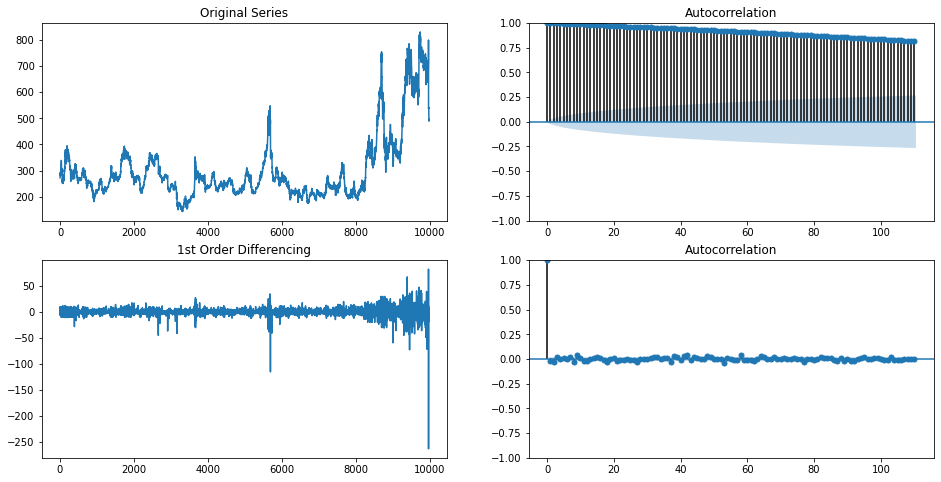

In [68]:
# ACF no decomp, 1 diff

plt.rcParams.update({'figure.figsize':(16,8)})

# Original Series
fig, axes = plt.subplots(2, 2)#, sharex=True)
axes[0, 0].plot(true_in['value'].dropna().values)
axes[0, 0].set_title('Original Series')
series_data = true_in['value'].values
lags_n = 110
plot_acf(series_data, ax=axes[0, 1], lags=lags_n)

# 1st Differencing
axes[1, 0].plot(true_in['value'].diff().values)
axes[1, 0].set_title('1st Order Differencing')
first_diff_series = true_in['value'].diff().dropna().values
first_diff_lags_n = 110
plot_acf(first_diff_series, ax=axes[1, 1], lags=first_diff_lags_n)

plt.show()

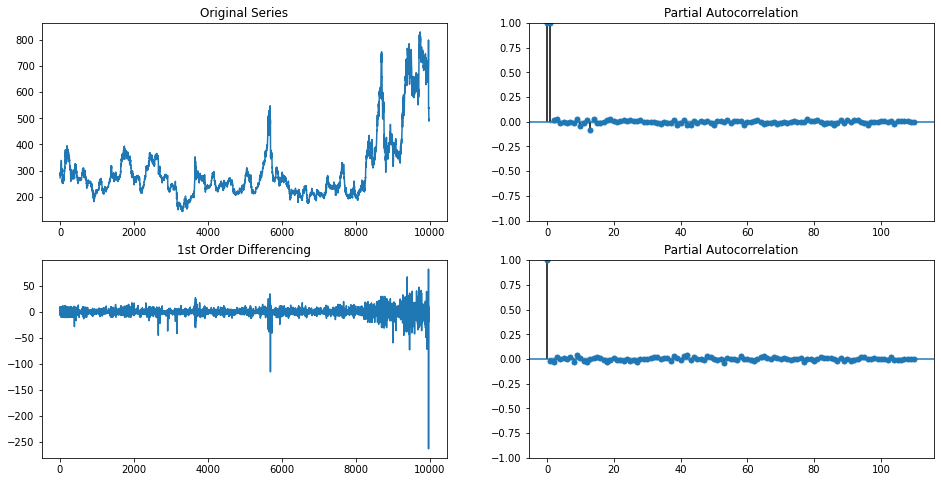

In [69]:
# PACF no decomp, 1 diff

plt.rcParams.update({'figure.figsize':(16,8)})

# Original Series
fig, axes = plt.subplots(2, 2)#, sharex=True)
axes[0, 0].plot(true_in['value'].dropna().values)
axes[0, 0].set_title('Original Series')
series_data = true_in['value'].values
lags_n = 110
plot_pacf(series_data, ax=axes[0, 1], lags=lags_n, method='ywm')

# 1st Differencing
axes[1, 0].plot(true_in['value'].diff().values)
axes[1, 0].set_title('1st Order Differencing')
first_diff_series = true_in['value'].diff().dropna().values
first_diff_lags_n = 110
plot_pacf(first_diff_series, ax=axes[1, 1], lags=first_diff_lags_n, method='ywm')

plt.show()

In [70]:
# Looks like p=1, q=1 at most
# ARIMA doesn't seem suitable for this series - non-decomposed investiagations stop here

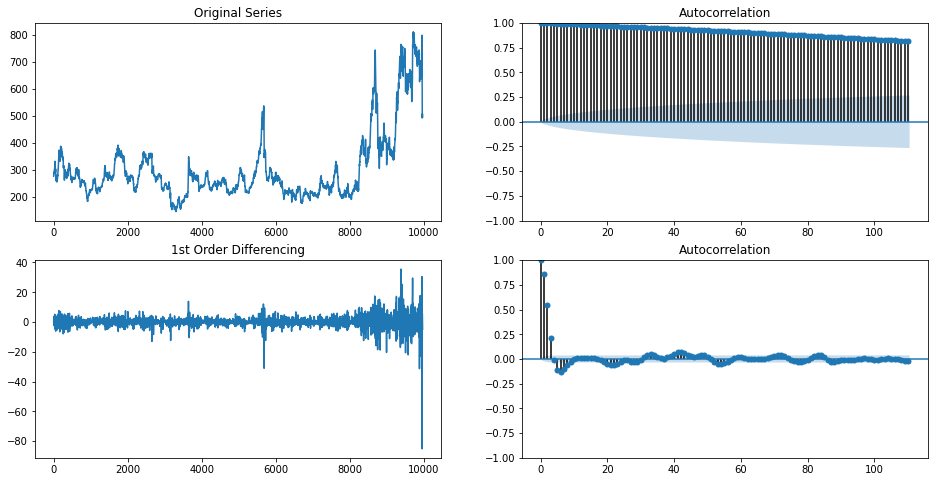

In [71]:
# ACF emd, 1 diff

plt.rcParams.update({'figure.figsize':(16,8)})

# Original Series
fig, axes = plt.subplots(2, 2)#, sharex=True)
axes[0, 0].plot(emd_in['value'].dropna().values)
axes[0, 0].set_title('Original Series')
series_data = emd_in['value'].values
lags_n = 110
plot_acf(series_data, ax=axes[0, 1], lags=lags_n)

# 1st Differencing
axes[1, 0].plot(emd_in['value'].diff().values)
axes[1, 0].set_title('1st Order Differencing')
first_diff_series = emd_in['value'].diff().dropna().values
first_diff_lags_n = 110
plot_acf(first_diff_series, ax=axes[1, 1], lags=first_diff_lags_n)

plt.show()

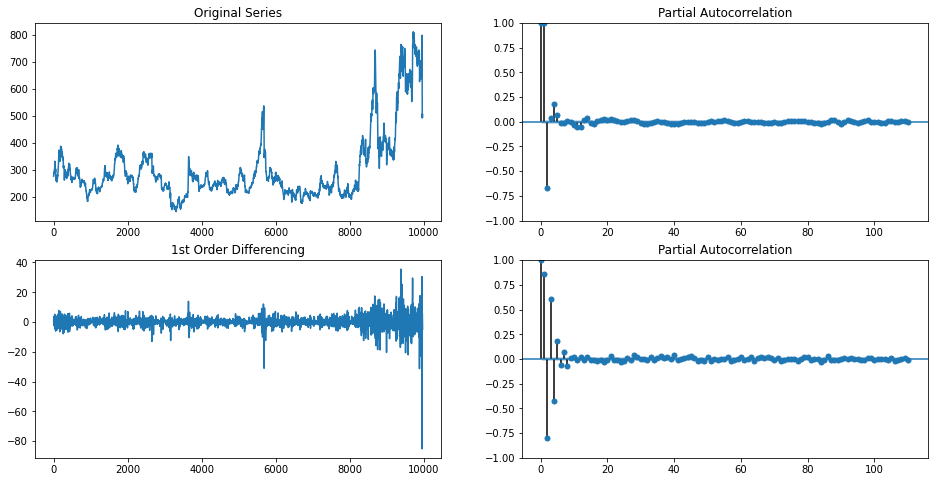

In [72]:
# PACF emd, 1 diff

plt.rcParams.update({'figure.figsize':(16,8)})

# Original Series
fig, axes = plt.subplots(2, 2)#, sharex=True)
axes[0, 0].plot(emd_in['value'].dropna().values)
axes[0, 0].set_title('Original Series')
series_data = emd_in['value'].values
lags_n = 110
plot_pacf(series_data, ax=axes[0, 1], lags=lags_n, method='ywm')

# 1st Differencing
axes[1, 0].plot(emd_in['value'].diff().values)
axes[1, 0].set_title('1st Order Differencing')
first_diff_series = emd_in['value'].diff().dropna().values
first_diff_lags_n = 110
plot_pacf(first_diff_series, ax=axes[1, 1], lags=first_diff_lags_n, method='ywm')

plt.show()

In [73]:
# Could be as many as 3 autoregressive terms and 5 moving average terms

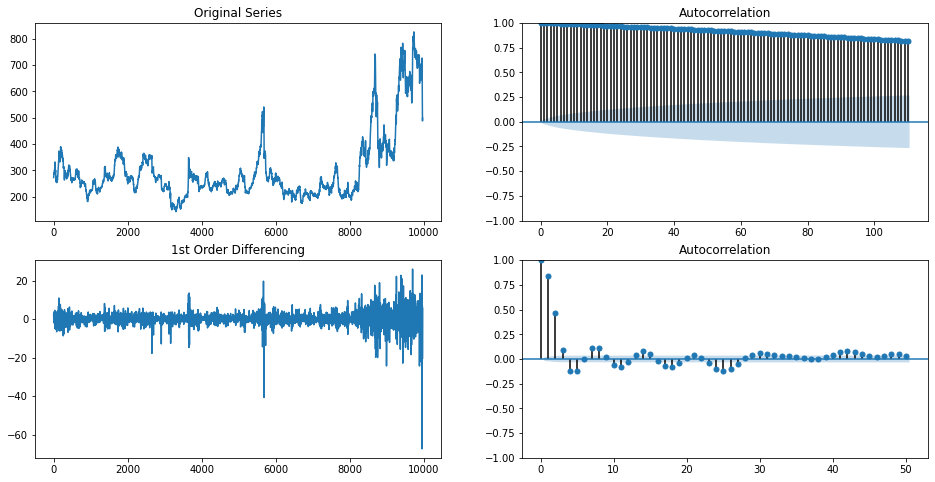

In [74]:
# ACF vmd, 1 diff

plt.rcParams.update({'figure.figsize':(16,8)})

# Original Series
fig, axes = plt.subplots(2, 2)#, sharex=True)
axes[0, 0].plot(vmd_in['value'].dropna().values)
axes[0, 0].set_title('Original Series')
series_data = vmd_in['value'].values
lags_n = 110
plot_acf(series_data, ax=axes[0, 1], lags=lags_n)

# 1st Differencing
axes[1, 0].plot(vmd_in['value'].diff().values)
axes[1, 0].set_title('1st Order Differencing')
first_diff_series = vmd_in['value'].diff().dropna().values
first_diff_lags_n = 50
plot_acf(first_diff_series, ax=axes[1, 1], lags=first_diff_lags_n)

plt.show()

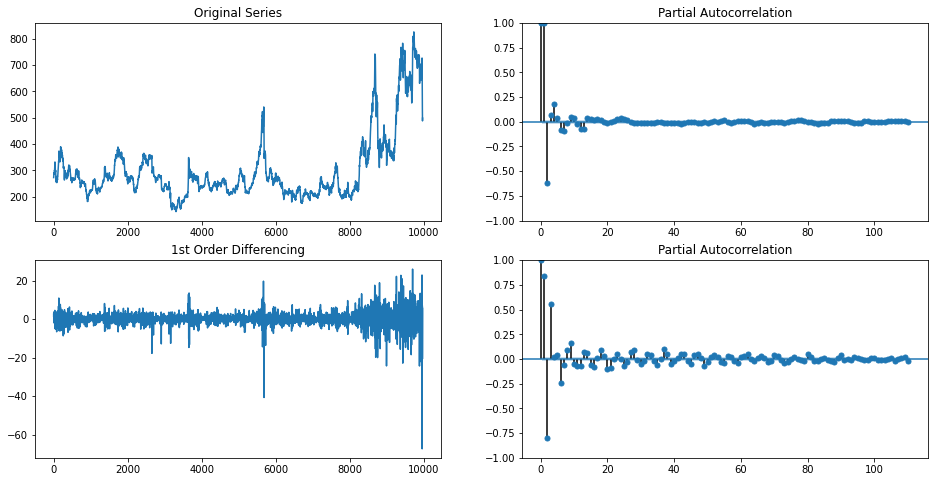

In [75]:
# PACF vmd, 1 diff

plt.rcParams.update({'figure.figsize':(16,8)})

# Original Series
fig, axes = plt.subplots(2, 2)#, sharex=True)
axes[0, 0].plot(vmd_in['value'].dropna().values)
axes[0, 0].set_title('Original Series')
series_data = vmd_in['value'].values
lags_n = 110
plot_pacf(series_data, ax=axes[0, 1], lags=lags_n, method='ywm')

# 1st Differencing
axes[1, 0].plot(vmd_in['value'].diff().values)
axes[1, 0].set_title('1st Order Differencing')
first_diff_series = vmd_in['value'].diff().dropna().values
first_diff_lags_n = 110
plot_pacf(first_diff_series, ax=axes[1, 1], lags=first_diff_lags_n, method='ywm')

plt.show()

In [76]:
# looks like p is 2 or 3, q up to 3
# Pattern in acf/pacf: basis for seasonality??

# 4 Investigate model order

In [77]:
emd_arima = pm.auto_arima(emd_in, start_p=0, start_q=0,
                      test='adf',
                      max_p=3, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=1,              # stationarity is achieved with one differencing
                      seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      max_order=7)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=53453.431, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39779.825, Time=1.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=40948.002, Time=6.68 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=53451.822, Time=0.27 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=29729.009, Time=3.96 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=25034.078, Time=3.93 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=22542.493, Time=8.76 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23625.259, Time=5.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=22447.048, Time=5.47 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=22586.316, Time=3.58 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=22405.477, Time=18.91 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=22418.443, Time=5.12 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=22376.007, Time=21.24 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=22377.147, Time=9.99 sec
 ARIMA(3,1,5)(0,0

In [78]:
# auto arima vmd
vmd_arima = pm.auto_arima(vmd_in, start_p=0, start_q=0,
                      test='adf',
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=1,              # stationarity is achieved with one differencing
                      seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      max_order=6)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=52761.933, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40586.904, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=40841.387, Time=2.61 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=52760.372, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=30235.598, Time=1.23 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=26535.284, Time=1.94 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=26532.292, Time=14.57 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=27344.551, Time=2.74 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=26530.025, Time=4.86 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=27132.595, Time=3.77 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=21.44 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=26387.956, Time=5.76 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=27908.534, Time=7.62 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=16.75 sec
 ARIMA(2,1,3)(0,0,0)[0]     

# 5 Generate validation set predictions, for use in forecast combination step

In [7]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [81]:
predictions_rolling = []

for i in range(len(emd_valid)):

  train_set = pd.concat([emd_train, emd_valid[:i]]) #concatenating here is quite inefficient, and avoidable

  emd_arima_model = ARIMA(train_set['value'].dropna().values, order=(3, 1, 5), enforce_stationarity=False)  
  emd_arima_fit = emd_arima_model.fit()

  fc = emd_arima_fit.forecast()
  predictions_rolling.append(fc[0])

with open(f'/content/gdrive/My Drive/outputs/emd_ARIMA_daily_valid.json', 'w') as fp:
  json.dump(predictions_rolling, fp)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: 

In [9]:
predictions_rolling = []

for i in range(len(vmd_valid)):

  train_set = pd.concat([vmd_train, vmd_valid[:i]]) #concatenating here is quite inefficient, and avoidable

  vmd_arima_model = ARIMA(train_set['value'].dropna().values, order=(2, 1, 3), enforce_stationarity=False)  
  vmd_arima_fit = vmd_arima_model.fit()

  fc = vmd_arima_fit.forecast()
  predictions_rolling.append(fc[0])

with open(f'/content/gdrive/My Drive/outputs/vmd_ARIMA_daily_valid.json', 'w') as fp:
  json.dump(predictions_rolling, fp)

# End